In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.metrics import (precision_score, recall_score, f1_score, 
                             roc_auc_score, average_precision_score, 
                             classification_report, confusion_matrix, roc_curve)
import time
import os
import pickle
import joblib

In [11]:
TRAIN_PATH = "D:/train_processed.csv"
TEST_PATH  = "D:/test_processed.csv"

RANDOM_STATE = 42
TARGET_COL = None  # Sẽ lấy cột cuối cùng làm label

train_df = pd.read_csv(TRAIN_PATH)
test_df  = pd.read_csv(TEST_PATH)

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")

# Lấy cột cuối cùng làm label
TARGET_COL = train_df.columns[-1]
print(f"Target column (last column): '{TARGET_COL}'")

# Kiểm tra tập test có cột nhãn tương ứng
if TARGET_COL not in test_df.columns:
    raise ValueError("File test không chứa cột nhãn tương ứng.")

# Tách feature và label
X_train = train_df.iloc[:, :-1]          # Tất cả cột trừ cột cuối
y_train = train_df.iloc[:, -1].astype(int)  

X_test  = test_df.iloc[:, :-1]
y_test  = test_df.iloc[:, -1].astype(int)

X_test = X_test[X_train.columns]

print(f"Số lượng feature: {X_train.shape[1]}")


Train shape: (397649, 31)
Test shape:  (85443, 31)
Target column (last column): 'Class'
Số lượng feature: 30


[0]	validation_0-auc:0.95041
[100]	validation_0-auc:0.97224
[165]	validation_0-auc:0.97155
Thời gian train: 17.13s


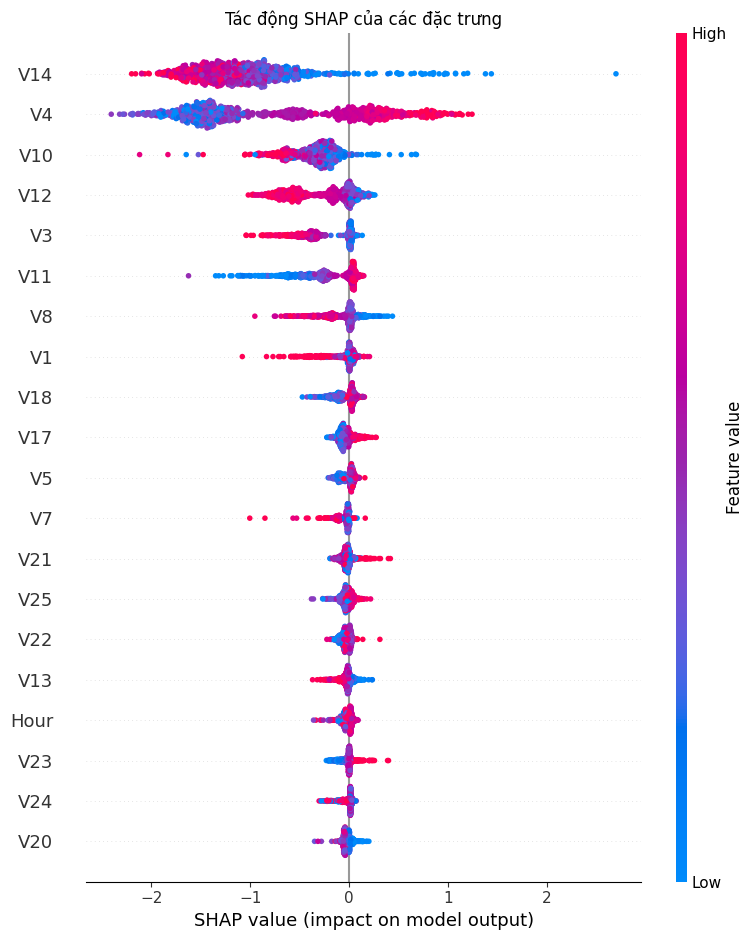

In [12]:
xgb_model = xgb.XGBClassifier(
    n_estimators=1000,
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",
    early_stopping_rounds=50,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

start_time = time.time()
# Fit trực tiếp trên X_train, y_train (đã processed)
xgb_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=100
)
print(f"Thời gian train: {time.time() - start_time:.2f}s")
explainer = shap.TreeExplainer(xgb_model)
# Lấy mẫu ngẫu nhiên để vẽ (tăng tốc độ)
X_sample = X_test.sample(n=min(1000, len(X_test)), random_state=RANDOM_STATE)
shap_values = explainer(X_sample)

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values.values, X_sample, show=False)
plt.title("Tác động SHAP của các đặc trưng")
plt.tight_layout()
plt.show()


--- Model Performance ---
Precision      : 0.1809
Recall         : 0.8581
F1-Score       : 0.2988
AUC-ROC        : 0.9726
Avg Precision  : 0.6930

Classification Report:
               precision    recall  f1-score   support

           0     0.9998    0.9933    0.9965     85295
           1     0.1809    0.8581    0.2988       148

    accuracy                         0.9930     85443
   macro avg     0.5903    0.9257    0.6477     85443
weighted avg     0.9983    0.9930    0.9953     85443



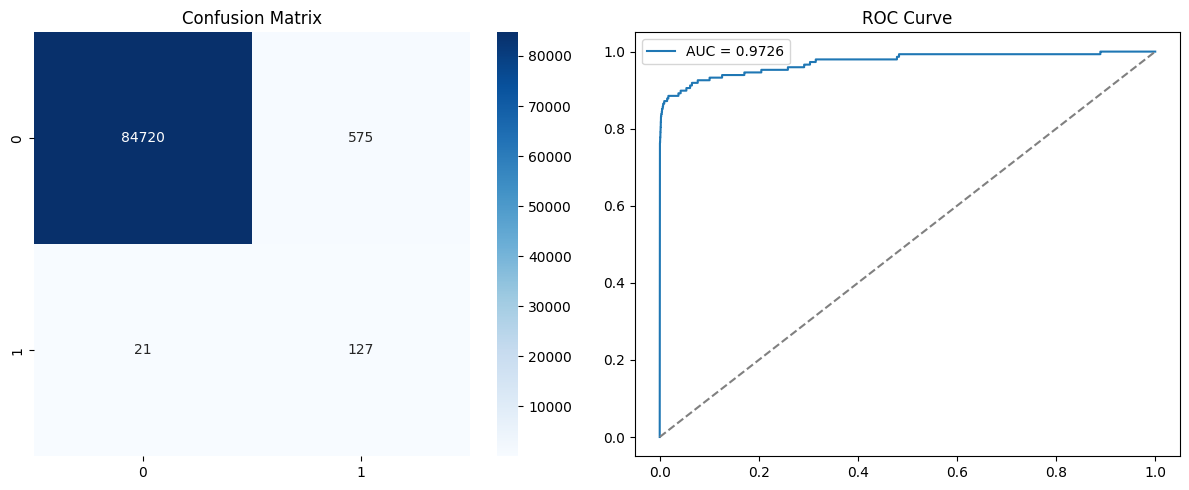

In [13]:
# Đánh giá mô hình
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

metrics = {
    "Precision": precision_score(y_test, y_pred, zero_division=0),
    "Recall": recall_score(y_test, y_pred, zero_division=0),
    "F1-Score": f1_score(y_test, y_pred, zero_division=0),
    "AUC-ROC": roc_auc_score(y_test, y_proba),
    "Avg Precision": average_precision_score(y_test, y_proba)
}

print("\n--- Model Performance ---")
for k, v in metrics.items():
    print(f"{k:<15}: {v:.4f}")

print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))

# Visualization
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax[0])
ax[0].set_title("Confusion Matrix")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
ax[1].plot(fpr, tpr, label=f"AUC = {metrics['AUC-ROC']:.4f}")
ax[1].plot([0, 1], [0, 1], "--", color="gray")
ax[1].set_title("ROC Curve")
ax[1].legend()

plt.tight_layout()
plt.show()

In [ ]:

# Cấu hình đường dẫn
MODEL_OUT_DIR = "D:/fraud_model_artifacts"
os.makedirs(MODEL_OUT_DIR, exist_ok=True)

MODEL_FILE = os.path.join(MODEL_OUT_DIR, "xgb_model.joblib")
EXPLAINER_FILE = os.path.join(MODEL_OUT_DIR, "shap_explainer.pkl")
FEATURES_FILE = os.path.join(MODEL_OUT_DIR, "feature_names.pkl")

class FraudDetectionSystem:
    def __init__(self, model, explainer, feature_names, threshold=0.5):
        self.model = model
        self.explainer = explainer
        self.feature_names = list(feature_names)
        self.threshold = float(threshold)

    def _prepare_df(self, df_in):
        if isinstance(df_in, dict):
            df = pd.DataFrame([df_in])
        else:
            df = df_in.copy()
        
        # Fill cột thiếu bằng 0
        for col in self.feature_names:
            if col not in df.columns:
                df[col] = 0.0
        
        # Sắp xếp đúng thứ tự
        return df[self.feature_names]

    def _risk_level(self, p):
        if p >= 0.9: return "VERY HIGH"
        elif p >= 0.7: return "HIGH"
        elif p >= 0.5: return "MEDIUM"
        elif p >= 0.3: return "LOW"
        else: return "VERY LOW"

    def predict_single(self, transaction):
        df = self._prepare_df(transaction)
        proba = float(self.model.predict_proba(df)[0, 1])
        pred = int(proba >= self.threshold)
        
        shap_vals = self.explainer(df).values[0]
        
        feat_df = pd.DataFrame({
            "feature": self.feature_names,
            "value_raw": df.iloc[0].values,
            "shap_value": shap_vals
        })
        feat_df["abs_shap"] = feat_df["shap_value"].abs()
        top_feats = feat_df.sort_values("abs_shap", ascending=False).head(10).to_dict("records")

        return {
            "is_fraud": bool(pred),
            "fraud_probability": proba,
            "risk_level": self._risk_level(proba),
            "top_features": top_feats
        }

joblib.dump(xgb_model, MODEL_FILE)
with open(EXPLAINER_FILE, "wb") as f:
    pickle.dump(explainer, f)
with open(FEATURES_FILE, "wb") as f:
    pickle.dump(X_train.columns.tolist(), f)

print(f"Artifacts đã được lưu tại: {MODEL_OUT_DIR}")

Artifacts đã được lưu tại: D:/fraud_model_artifacts
